In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.assignment2.simulation import HospitalSimulation, PatientState, WardType, WardConfig, WardsConfigurations, HospitalConfiguration, hist_performance
from scipy import stats
import numpy as np
import seaborn as sns


In [3]:

configs = [
    WardConfig(bed_capacity=55, urgency=7, mean_arrival_time=1/14.5, 
        mean_stay_time=2.9),
    WardConfig(40, 5, 1/11, 4),
    WardConfig(30, 2, 1/8, 4.5),
    WardConfig(20, 10, 1/6.5, 1.4),
    WardConfig(20, 5, 1/5, 3.9),
    WardConfig(0, 0, 1/13, 2.2)
]

configs_nof = configs.copy()
del configs_nof[-1]

std_configs = WardsConfigurations(configs)
std_switch = {
    WardType.A: [0.0, 0.05, 0.10, 0.05, 0.80, 0.0],
    WardType.B: [0.20, 0.0, 0.50, 0.15, 0.15, 0.0],
    WardType.C: [0.30, 0.20, 0.0, 0.20, 0.30, 0.0],
    WardType.D: [0.35, 0.30, 0.05, 0.0, 0.30, 0.0],
    WardType.E: [0.20, 0.10, 0.60, 0.10, 0.0, 0.0],
    WardType.F: [0.20, 0.20, 0.20, 0.20, 0.20, 0.0]
}

def mean_exp_dist(mean_time):
    return stats.expon.rvs(scale=mean_time)

sim_config = HospitalConfiguration(std_configs, std_switch, mean_exp_dist, mean_exp_dist)
hsim = HospitalSimulation(sim_config)

In [4]:
result_withoutf = hsim.sim_multiple_without_f(10)


/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/env

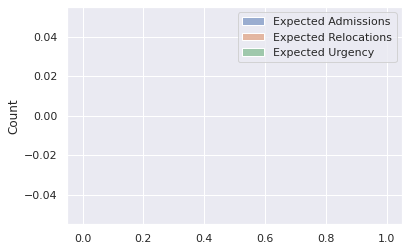

In [5]:
hist_performance(result_withoutf)


In [ ]:
result.expected_admissions(list(WardType))

,mean,lwr,upr
A,5273.3,5254.742942,5291.857058
B,649.2,616.540129,681.859871
C,23.9,22.284121,25.515879
D,2350.6,2330.422522,2370.777478
E,144.6,136.402237,152.797763
F,4505.1,4487.314107,4522.885893


In [ ]:
result.expected_relocations(list(WardType))

,mean,lwr,upr
A,12.8,9.509573,16.090427
B,3347.9,3309.887551,3385.912449
C,2912.7,2891.329900,2934.070100
D,0.2,-0.480781,0.880781
E,1697.2,1686.131716,1708.268284
F,236.5,235.524791,237.475209


In [13]:
result.expected_penalty()

/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/simon/anaconda3/envs/StochSim/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,mean,lwr,upr
A,154.0,129.232250,178.767750
B,16622.5,16367.362153,16877.637847
C,5792.6,5750.328270,5834.871730
D,0.0,NaN,NaN
E,8477.5,8362.735000,8592.265000
F,0.0,NaN,NaN


In [6]:
## Example of setting bed distribution, individually and alltogether
hsim.ward_configs[WardType.A].bed_capacity = 40
hsim.ward_configs.bed_distribution = [100, 40, 10, 10, 10, 0]

## Example setting new distributions
def mean_lognorm_sd2(mean_time):
    s = 2/mean_time**2
    mu = mean_time * np.exp(-s**2/2)
    return stats.lognorm(scale=mu, s=np.sqrt(s)).rvs()

hsim.stay_dist = mean_lognorm_sd2
